In [1]:
import valenspy as vp
from valenspy._utilities import load_yml
import xarray as xr
from pathlib import Path
import cdo

# Load your data
Here we load ERA-5 and CCLM data.
### ERA-5 Data

In [6]:
#ERA-5 data
manager = vp.InputManager(machine="hortense")
ds_ref = manager.load_data("ERA5","tas", period=[1995,1995],freq="daily",region="europe", path_identifiers = ["-daily-"])


File paths found:
/dodrio/scratch/projects/2022_200/project_input/External/observations/era5/europe/daily/2m_temperature/era5-daily-europe-2m_temperature-1995.nc
The file is ValEnsPy CF compliant.
50.00% of the variables are ValEnsPy CF compliant
ValEnsPy CF compliant: ['tas']
Unknown to ValEnsPy: ['time_bnds']


### CCLM Data
This will be simplified in the future with an CCLM input convertor which could in turn be taken up by the InputManager.

In [2]:
dataset_PATHS = load_yml("dataset_PATHS")
model_directory = dataset_PATHS["hortense"]["CCLM"]
mod_LOOKUP = load_yml(f"CCLM_lookup")

# get CCLM variable corresponding to the requested variable using its look-up table
mod_var = mod_LOOKUP["tas"]['mod_name']

# define the path
directory = Path(model_directory + "EUR11_CO_TA_GC_TSO" +'/'+mod_var + '/')

# define the CCLM files for the corresponding variable
mod_files = list(directory.glob(mod_var+"_daymean.nc")) # Se
ds_mod = xr.open_mfdataset(mod_files, combine="by_coords", chunks="auto")

# Regridding
Now we can regrid the model data to the ERA-5 grid. Here we use CDO. To make the workflow easier, we will use the CDO Python bindings to do this. A ValEnsPy function has been added to simplify this even further.

### Loading the CDO module
First we need to load the CDO module as this is not installed in the environment by default. On most systems this can be done by running `module load CDO` in the terminal. 

To use it in the notebook as illustrated below you need to `module load CDO` in the terminal before starting the vscode server in the same terminal.

Loading the module in the notebook itself will not work. On the vsc I have added `module load CDO` to the `~/.bashrc` file so it is loaded automatically when starting the server. Not ideal but it works until the VSC dashboard allows to add code before starting the vscode server.

Another workaround is using python files. Try to run the following in a terminal with the CDO module loaded. This will give the same result as this notebook.
```bash
python regridding_example.py
```

If CDO is loaded `!which cdo` should return the path to the cdo executable.

In [4]:
!which cdo #Check if the cdo module is loaded (If this does not provide a path, you need to load the cdo module)

/readonly/dodrio/apps/RHEL8/zen2-ib/software/CDO/2.1.1-gompi-2021a/bin/cdo


Now let's regrid the data. Note that the gridfile can be:
- a path to a .nc file with the target grid
- a string with the target grid name (e.g. 'r360x180') for a global regular grid
- a path to a grid description file (e.g. a .txt file with the grid description)

See cdo documentation for more information on the grid description file: https://code.mpimet.mpg.de/projects/cdo/embedded/cdo.pdf

In [7]:
gridfile = manager._get_file_paths('ERA5', "tas", period=[1995, 1995], freq="daily", region="europe", path_identifiers = ["-daily-"])[0]

from valenspy.preprocessing_tasks.regrid import remap_cdo
ds_mod_regrid = remap_cdo(gridfile, ds_mod, remap_method="bil")

ds_mod_regrid = ds_mod_regrid.rename({"T_2M": "tas"})

Note that the data to be regridded and the regridded output data remains in xarray format. However, the target grid cannot be an xarray dataset but must be a path to a .nc file or other valid grid description.

# Plotting 
Finally we can plot the difference and see if the regridding worked as expected. Or other nicer diagnostics can be applied.

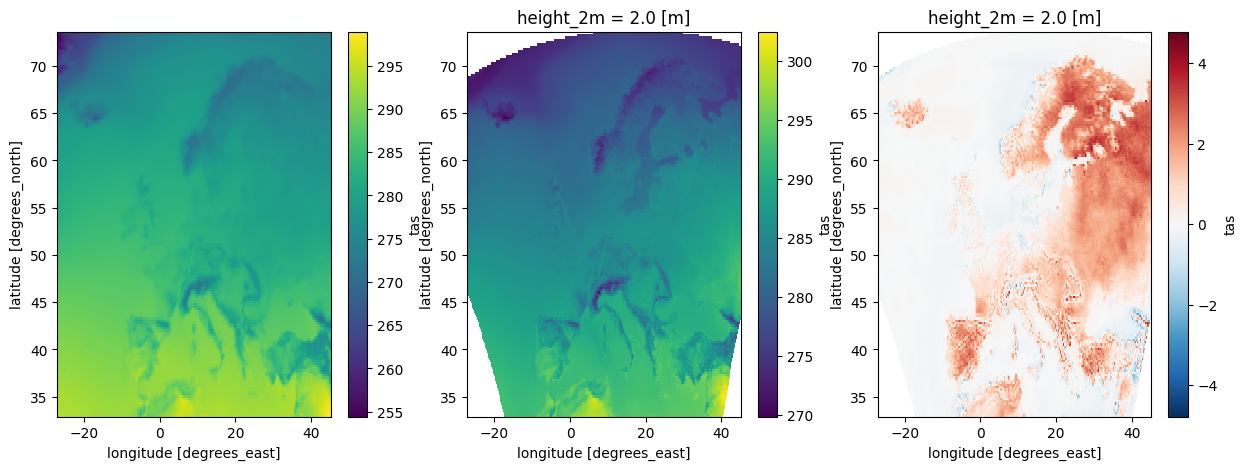

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ds_ref["tas"].mean("time").plot(ax=ax[0])
ds_mod_regrid["tas"].mean("time").plot(ax=ax[1])
(ds_ref["tas"]-ds_mod_regrid["tas"]).mean("time").plot(ax=ax[2])